# Caso Práctico de Módulo 3: Implementación de un Sistema de Recomendación de películas: MovieLens


* En este Notebook vamos a implementar y evaluar un ***Sistema de Recomendación basado en Filtrado Colaborativo con KNN*** usando la base de datos de [MovieLens 100K](https://grouplens.org/datasets/movielens/).


* Esta base de datos contiene 100.000 votos con notas de 1 a 5 de 943 usuarios sobre 1682 películas.


* Este dataset ha sido dividido en votaciones de entrenamiento (80%) y votaciones de test (20%). Además para simplificar el problema, los códigos de usuarios e items, han sido modificados para que comience en 0 y terminen en el número de (usuarios / items) - 1.


* Para ***implementar y evaluar este Sistema de Recomendación*** realizaremos los siguientes paso:
<span></span><br>
    1. [Lectura del Dataset (Entrenamiento y Test)](#M1)
<span></span><br>
    2. [Cálculo de similaridades](#M2)
<span></span><br>
    3. [Cálculo de los K-Vecinos](#M3)
<span></span><br>
    4. [Cálculo de las Predicciones](#M4)
<span></span><br>
    5. [Cálculo de las recomendaciones(*)](#M5)
<span></span><br>
    6. [Evaluación del Sistema de Recomendación (MAE)](#M6)
<span></span><br>
    7. [Sistema de Recomendación y Evaluación](#M7)


##### (*): El punto del cálculo de las Recomendaciones no lo vamos a realizar ya que este punto no es relevante de cara a evaluar el sistema de recomendación implementado.


<hr>


# <a name="M1">1.- Lectura del Dataset (Entrenamiento y Test)
    
    
* A continuación implementamos una función que data la ruta donde se encuentra un fichero con la estructura "ID_USER::ID_MOVIE::RATING" nos devuelva una matriz de votos:

In [1]:
def read_ratings_matrix(file):

    ratings = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]

    with open(file, 'r') as reader:
        for line in reader:
            [u, i, rating] = line.split("::")
            ratings[int(u)][int(i)] = int(rating)

    return ratings

<hr>


# <a name="M2"> 2.- Cálculo de *Similaridades*


* A continuación implementamos una función que dada una matriz de votos y una métrica de similaridad, nos devuelva una matriz de similaridades entre cada par de usuarios.


* Tambien implemantamos las métricas de similaridad de:
    + MSD
    + Coseno
    + Correlación de Pearson
    + JMSD

In [2]:
def calculate_similarities(ratings_matrix, similarity_metric):

    # Creamos una matriz con valores de similaridad a -1
    similarities = [[float('-inf') for _ in range(NUM_USERS)] for _ in range(NUM_USERS)]

    # Recorremos la matriz por usuario
    for i, u in enumerate(ratings_matrix):
        if i%100==0:
            print("\tProcesandos {} Usuarios".format(i))
        for j, v in enumerate(ratings_matrix):
            if j != i: # No calculamos la similaridad para un mismo usuario
                similarities[i][j] = similarity_metric(u,v)

    return similarities


def rating_average(ratings):

    acc = 0
    count = 0
    for id_item in range(len(ratings)):
        if ratings[id_item] != None:
            acc += ratings[id_item]
            count += 1
    return acc / count


def msd_similarity(u, v):

    sum_r = 0
    count = 0

    for i in range(len(u)):
        if u[i] != None and v[i] != None:
            count += 1
            sum_r += math.pow((u[i] - v[i])/(MAX_RATING - MIN_RATING), 2)

    if count > 0:
        sim = 1-(sum_r/float(count))
        return sim
    else:
        return None


def cosine_similarity(u, v):

    numerador = 0
    denominador_u = 0
    denominador_v = 0

    count = 0

    for i in range(len(u)):
        if u[i] != None and v[i] != None:
            numerador += u[i] * v[i]
            denominador_u += math.pow(u[i], 2)
            denominador_v += math.pow(v[i], 2)
            count += 1
    if count > 0 and denominador_u != 0 and denominador_v != 0:
        cos = numerador / (math.sqrt(denominador_u) * math.sqrt(denominador_v))
        return cos
    else:
        return None


def jmsd_similarity(u, v):

    union = 0
    intersection = 0

    for i in range(len(u)):
        if u[i] != None and v[i] != None:
            intersection += 1
            union += 1
        elif u[i] != None or v[i] != None:
            union += 1

    if intersection > 0:
        jaccard = intersection / union
        return jaccard * msd_similarity(u,v)
    else:
        return None


<hr>


# <a name="M3"> 3.- Cálculo de los *K-Vecinos*
    
    
* A continuación implementamos una función que dada una matriz de similaridades entre usuarios y un valor de 'K' (número de vecinos a calcular), nos devuelva una matriz de "NUM_USERS x K_VECINOS" indicando los vecinos de cada usuario:

In [3]:
def calculate_neighbors(similarities_matrix, k_neighbors):

    neighbors = [None for _ in range(NUM_USERS)]

    for index, similarities in enumerate(similarities_matrix):
        i_neighbors = [i[0] for i in sorted(enumerate(similarities),
                                            key=lambda x:float('-inf') if x[1] is None else x[1],
                                            reverse=True)]
        neighbors[index] = i_neighbors[0:k_neighbors]

    return neighbors

<hr>


# <a name="M4"> 4.- Cálculo de las *Predicciones*
    
    
* A continuación implementamos un método que nos calcule las predicciones de los votos que emitirian los usuarios sobre los items con el método de agregación de "Media Ponderada":

In [4]:
def calculate_weighted_average_prediction(ratings_matrix, similarities_matrix, neighbors):

    # Creamos una matriz para el cálculo de predicciones
    predictions = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]

    # Recorremos la matriz de votos
    for i, u in enumerate(ratings_matrix):
        for j, v in enumerate(ratings_matrix[0]):
            # Obtenemos las similaridades con cada vecino y si voto
            numerador = 0
            denominador = 0
            for neighbor in neighbors[i]:
                if ratings_matrix[neighbor][j] != None:
                    numerador += similarities_matrix[i][neighbor] * ratings_matrix[neighbor][j]
                    denominador += similarities_matrix[i][neighbor]

            predictions[i][j] = None if denominador == 0 else numerador/denominador

    return predictions


<hr>


# <a name="M6"> 6.- Evaluación del Sistema de Recomendación (MAE)
    
    
* A continuación se implementa un método que dada la matriz de votos y la matriz de predicciones nos devuelve el MAE del Sistema de Recomendación:

In [5]:
def get_mae(ratings_matrix, predictions_matrix):

    mae_users = [None for _ in ratings_matrix]

    # Recorremos la matriz de votos
    for i, u in enumerate(ratings_matrix):
        # Calculamos el MAE de cada usuario
        sum_user = 0
        count = 0
        for j, v in enumerate(ratings_matrix[0]):
            if ratings_matrix[i][j] != None and predictions_matrix[i][j] != None:
                sum_user += abs(ratings_matrix[i][j] - predictions_matrix[i][j])
                count += 1
        mae_users[i] = sum_user/count if count > 0 else None

    return np.nanmean(np.array(mae_users, dtype=np.float), axis=0)

<hr>


# <a name="M7">7.- Sistema de Recomendación y Evaluación
    
    
* A continuación se implementa el "Sistema de Recomendación", en el cual:
    + Calcularemos las similaridades para distintas métricas de similaridad
    + Realizaremos las predicciones para diferentes números de vecinos
    + Evaluaremos para cada experimento los conjuntos de entrenamiento y test.

In [6]:
import math
import numpy as np
import pandas as pd

# Número de usuarios e items
NUM_USERS = 943
NUM_ITEMS = 1682

# Notas máximas y mínimas dadas en la matriz de votos
MIN_RATING = 1
MAX_RATING = 5

# Ruta del los datasets de entrenamiento y test
TRAIN_RATINGS_FILE = './data/movielens_100K_train_test/movielens_100k_training.txt'
TEST_RATINGS_FILE = './data/movielens_100K_train_test/movielens_100k_test.txt'

# Lectura de los Datasets de Entrenamiento y Test
train_ratings = read_ratings_matrix(file=TRAIN_RATINGS_FILE)
test_ratings = read_ratings_matrix(file=TEST_RATINGS_FILE)

# Metricas, K vecinos y predicciones a probar
SIMILARITIES_METRICS = [('MSD', msd_similarity),
                        ('COSENO', cosine_similarity),
                        ('JMSD', jmsd_similarity)]
K_NEIGHBORS = [25, 50, 100, 150, 200, 300, 400, 500]


# Guardo en una lista los experimentos realizados, siendo un experimento una lista con 4 posiciones:
#     1.- Métrica de similaridad
#     2.- Número de vecinos
#     3.- MAE
#     4.- Entrenamiento o Test
experiments = []

for metric in SIMILARITIES_METRICS:
    print('{}: Cálculo de similatidades'.format(metric[0]))
    similarities_matrix = None # TODO: llamar al método calculate_similarities
    for k in K_NEIGHBORS:

        print('  {} Vecinos'.format(k))
        neighbors_matrix = None # TODO: llamar al método calculate_neighbors

        # Calculamos las predicciones
        predictions = None # TODO: llamar al método calculate_weighted_average_prediction

        # Calculamos el MAE para entrenamiento y test
        mae_train = 0.0 # TODO: llamar al método get_mae
        mae_test = 0.0 # TODO: llamar al método get_mae

        # Añadimos los experimentos a la lista
        experiments.append([metric[0], k, mae_train, "Train"])
        experiments.append([metric[0], k, mae_test, "Test"])


FileNotFoundError: ignored

* Pasamos los resultados de los experimentos a un DataFrame:

In [7]:
# Pasamos los resultados de los experimentos a un DataFrame
df_results = pd.DataFrame.from_records(experiments,
                                       columns=['Metrica', 'K-Vecinos', 'MAE', 'Train/Test'])


NameError: ignored

* Mostramos los resultados de los experimentos con los datos de entrenamiento:

In [8]:
pd.pivot_table(df_results[df_results['Train/Test']=='Train'],
               values=['MAE'],
               index=['K-Vecinos'],
               columns=['Metrica'])

NameError: ignored

* Mostramos los resultados de los experimentos con los datos de test:

In [9]:
pd.pivot_table(df_results[df_results['Train/Test']=='Test'],
               values=['MAE'],
               index=['K-Vecinos'],
               columns=['Metrica'])

NameError: ignored

* Pintamos los resultados

<ipython-input-10-5b1574cfdf14>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


NameError: ignored

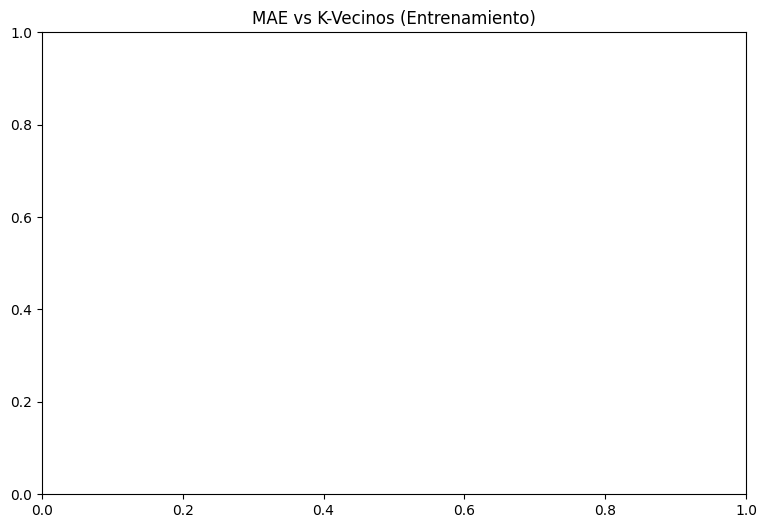

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize = (20, 6))
# Pintamos el MAE con los datos de Entrenamiento
plt.subplot(1, 2, 1)
plt.title('MAE vs K-Vecinos (Entrenamiento)')
sns.lineplot(x="K-Vecinos", y="MAE", hue="Metrica", data=df_results[df_results['Train/Test']=='Train'])

# Pintamos el MAE con los datos de Test
plt.subplot(1, 2, 2)
plt.title('MAE vs K-Vecinos (Test)')
sns.lineplot(x="K-Vecinos", y="MAE", hue="Metrica", data=df_results[df_results['Train/Test']=='Test'])

plt.show()

In [11]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error

# Ejemplo para calcular KNN y evaluar con MAE
k_values = [25, 50, 100, 150, 200, 300, 400, 500]
mae_results = []

for k in k_values:
    model = NearestNeighbors(n_neighbors=k)
    model.fit(train_data)  # Asumiendo que 'train_data' es tu conjunto de entrenamiento
    predictions = model.predict(test_data)  # Asumiendo que 'test_data' es tu conjunto de prueba

    mae = mean_absolute_error(test_targets, predictions)  # 'test_targets' son las verdaderas valoraciones
    mae_results.append(mae)

    print(f"MAE para k={k}: {mae}")


NameError: ignored

# **SOLUCIÓN**

Paso 1: Configuración Inicial

Importa todas las bibliotecas necesarias y configura tu entorno.

In [16]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error
from scipy.spatial.distance import cosine, correlation



Paso 2: Carga y Preparación de los Datos

Carga los datos desde un archivo y prepáralos para el análisis.

In [17]:
# Cargar los datos
data_path = '/path/to/movielens_100k.csv'  # Actualizar con la ruta correcta
df = pd.read_csv(data_path, delimiter=':::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python')

# Preparar los datos para el análisis
df['user_id'] = df['user_id'] - 1  # Asegurar que los IDs comienzan en 0
df['movie_id'] = df['movie_id'] - 1

# Crear una matriz usuario-película
max_user_id = df['user_id'].max()
max_movie_id = df['movie_id'].max()
user_movie_matrix = np.zeros((max_user_id + 1, max_movie_id + 1))
for row in df.itertuples():
    user_movie_matrix[row.user_id, row.movie_id] = row.rating

# Dividir en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


<ipython-input-17-94c0cc43cd85>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_path, sep=':::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])


FileNotFoundError: ignored

Paso 3: Construir el Modelo de Recomendación

Implementa un modelo de recomendación utilizando el algoritmo KNN.

In [15]:
# Función para calcular las predicciones
def predict_rating(user_id, movie_id, neighbors, user_movie_matrix):
    # Obtener los vecinos más cercanos
    distances, indices = neighbors.kneighbors(user_movie_matrix[user_id].reshape(1, -1), n_neighbors=k)

    # Calcular la predicción ponderada
    sum_weights = np.sum(distances)
    weighted_sum = np.dot(distances.flatten(), user_movie_matrix[indices.flatten(), movie_id])
    if sum_weights == 0:
        return 0
    return weighted_sum / sum_weights

# Definir el número de vecinos
k_values = [25, 50, 100, 150, 200, 300, 400, 500]


Paso 4. Cálculo de Similaridades


In [18]:
# Ejemplo usando la métrica de coseno
def calculate_similarity(data, metric='cosine'):
    if metric == 'cosine':
        similarity = 1 - cosine(data)
    # Puedes añadir más métricas aquí
    return similarity


Paso 4: Entrenar y Evaluar el Modelo

Entrena el modelo y evalúalo con diferentes valores de k.

In [19]:
# Entrenar y evaluar el modelo
for k in k_values:
    neighbors = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='cosine')
    neighbors.fit(user_movie_matrix)

    # Predecir ratings para el conjunto de prueba
    test_predictions = [predict_rating(row.user_id, row.movie_id, neighbors, user_movie_matrix) for row in test_data.itertuples()]

    # Calcular el MAE
    mae = mean_absolute_error(test_data['rating'], test_predictions)
    print(f'K: {k}, MAE: {mae}')


NameError: ignored

5. Cálculo de los K-Vecinos y Predicciones

In [20]:
# Ejemplo para calcular KNN
k_values = [25, 50, 100, 150, 200, 300, 400, 500]
mae_results = []

for k in k_values:
    model = NearestNeighbors(n_neighbors=k, metric=calculate_similarity)
    model.fit(train_data)
    predictions = model.predict(test_data)
    mae = mean_absolute_error(test_data['rating'], predictions)
    mae_results.append(mae)
    print(f"MAE para k={k}: {mae}")


NameError: ignored

6. Evaluación de los Modelos

In [ ]:
# Comparar los resultados del MAE para diferentes valores de k
for k, mae in zip(k_values, mae_results):
    print(f"K={k}, MAE={mae}")

# Determinar el mejor k basado en el menor MAE
best_k = k_values[np.argmin(mae_results)]
print(f"Mejor K: {best_k}")


In [21]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix

# Cargar los datos
data_path = 'path/to/movielens_100k.csv'  # Cambiar a la ruta correcta del archivo
df = pd.read_csv(data_path, delimiter=':::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python')

# Ajustar los IDs para que comiencen en 0
df['user_id'] = df['user_id'] - 1
df['movie_id'] = df['movie_id'] - 1

# Crear una matriz esparsa usuario-película
n_users = df['user_id'].nunique()
n_movies = df['movie_id'].nunique()
ratings_matrix = csr_matrix((df['rating'], (df['user_id'], df['movie_id'])), shape=(n_users, n_movies))

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Función para calcular las predicciones
def predict_rating(user_id, movie_id, neighbors, ratings_matrix):
    distances, indices = neighbors.kneighbors(ratings_matrix[user_id], n_neighbors=k)
    distances = 1 - distances.flatten()  # Convertir distancia en similitud
    sum_sim = np.sum(distances)
    weighted_ratings = sum(ratings_matrix[indices, movie_id].toarray().flatten() * distances) / sum_sim
    return weighted_ratings if sum_sim > 0 else 0

# Configurar diferentes valores de k y métricas de distancia
k_values = [25, 50, 100, 150, 200, 300, 400, 500]
metrics = ['cosine', 'euclidean', 'manhattan']
results = []

# Entrenar y evaluar el modelo con diferentes k y métricas
for metric in metrics:
    for k in k_values:
        print(f'Evaluating k={k}, metric={metric}')
        neighbors = NearestNeighbors(n_neighbors=k, algorithm='brute', metric=metric)
        neighbors.fit(ratings_matrix)
        test_predictions = [predict_rating(row.user_id, row.movie_id, neighbors, ratings_matrix) for row in test_data.itertuples()]
        mae = mean_absolute_error(test_data['rating'], test_predictions)
        results.append((metric, k, mae))
        print(f'MAE: {mae}')

# Mostrar los resultados
results_df = pd.DataFrame(results, columns=['Metric', 'K', 'MAE'])
print(results_df)

# Análisis final y conclusión
# Añadir aquí cualquier análisis adicional de los resultados


FileNotFoundError: ignored